# Mengimport library yang dipakai pada pembuatan model

In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

# Mengekstraksi data yang telah dikumpulkan dan melakuka preprocessing seperti merubah size menjadi (224,224) serta normalisasi

In [ ]:
def load_data(data_directory):
    images = []
    labels = []
    classes = []
    label_encoder = LabelEncoder()
    for class_name in os.listdir(data_directory):
        class_path = os.path.join(data_directory, class_name)
        classes.append(class_name)

        for filename in os.listdir(class_path):
            filepath = os.path.join(class_path, filename)
            img = cv2.imread(filepath)
# Data Processing:
# 1)merubah size gambar menjadi (224, 224),
# 2)melakukan normalisasi dengan membagi ke 255 dan mengatur menjadi RGB
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (224, 224))
                img = img / 255.0
                images.append(img)
                labels.append(class_name)

    images = np.array(images)
    labels = label_encoder.fit_transform(labels)

    return images, labels, classes

In [ ]:
data_directory = '/content/drive/MyDrive/jellyfish'
images, labels, classes =load_data(data_directory)

In [ ]:
# Membagi data Train dan data sementara yang akan saya bagi menjadi valid dan test
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
# Membagi data sementara sebanyak 50% menjadi valid dan test
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
print(f'Train set: {len(X_train)} samples')
print(f'Validation set: {len(X_valid)} samples')
print(f'Test set: {len(X_test)} samples')

Train set: 720 samples
Validation set: 90 samples
Test set: 90 samples


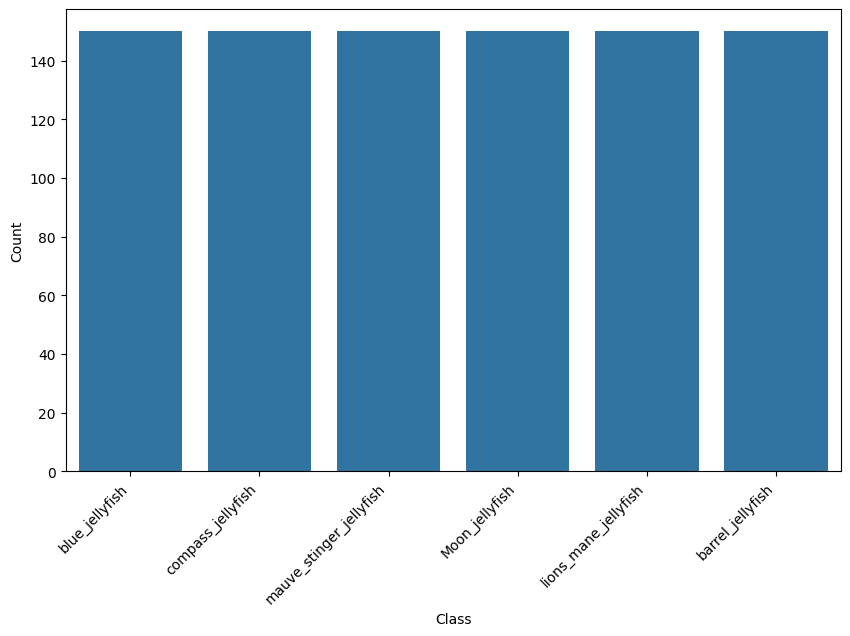

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x=[classes[label] for label in labels])
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

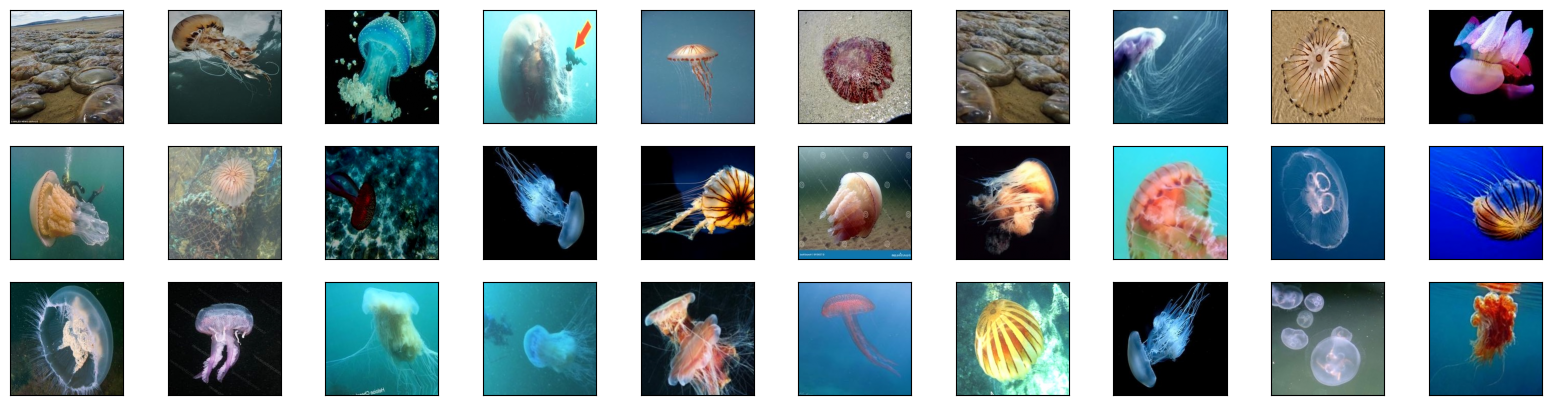

In [ ]:
fig = plt.figure(figsize=(20,5))

for i in range(30):
    ax = fig.add_subplot(3,10, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_train[i]))

In [ ]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=6)
y_valid = to_categorical(y_valid, num_classes=6)
y_test = to_categorical(y_test, num_classes=6)

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
)
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=20)
val_generator = val_datagen.flow(X_valid, y_valid, batch_size=20)

## Pembuatan arsitektur model menggunakan Convolutional Neural Network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import plot_model

In [ ]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(.3))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(.3))
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 28, 28, 64)       

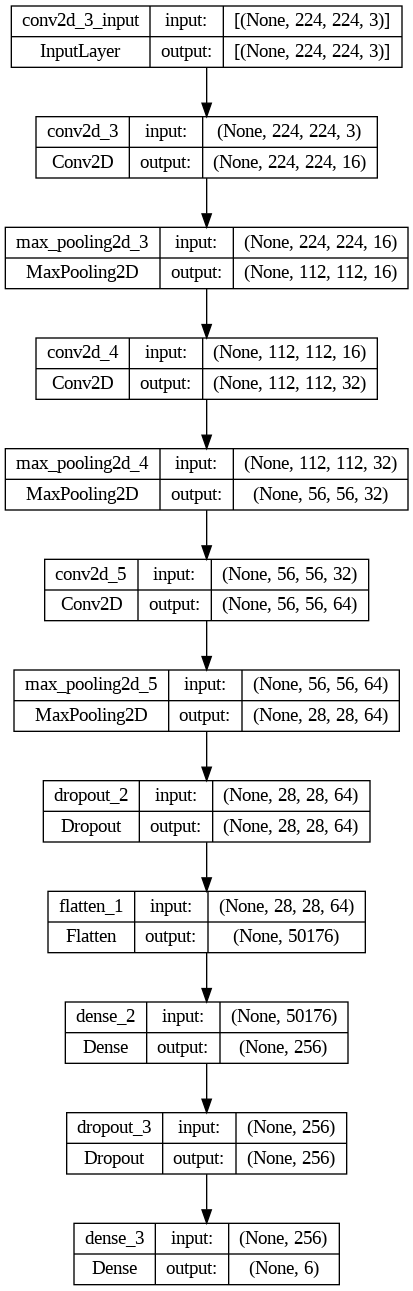

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

### Membuat callback agar training tidak berlangsung lama dengan menetapkan akurasi minimal 93% pada akurasi dan validation akurasi

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.93 and logs.get('accuracy')>0.93):
      print("\nModel telah menyentuh 93% akurasi, proses training berhenti")
      self.model.stop_training = True

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics =['accuracy'])

In [ ]:
callbacks = myCallback()
history = model.fit(train_generator, epochs=140, validation_data=val_generator, callbacks=callbacks)

Epoch 1/140
36/36 [==============================] - 9s 205ms/step - loss: 1.8851 - accuracy: 0.2264 - val_loss: 1.5708 - val_accuracy: 0.3333
Epoch 2/140
36/36 [==============================] - 8s 208ms/step - loss: 1.5218 - accuracy: 0.3681 - val_loss: 1.3553 - val_accuracy: 0.4000
Epoch 3/140
36/36 [==============================] - 11s 293ms/step - loss: 1.4660 - accuracy: 0.4083 - val_loss: 1.4127 - val_accuracy: 0.3778
Epoch 4/140
36/36 [==============================] - 9s 256ms/step - loss: 1.3609 - accuracy: 0.4278 - val_loss: 1.3533 - val_accuracy: 0.3889
Epoch 5/140
36/36 [==============================] - 7s 205ms/step - loss: 1.3310 - accuracy: 0.4333 - val_loss: 1.3065 - val_accuracy: 0.4000
Epoch 6/140
36/36 [==============================] - 9s 256ms/step - loss: 1.2748 - accuracy: 0.4861 - val_loss: 1.2611 - val_accuracy: 0.4778
Epoch 7/140
36/36 [==============================] - 8s 231ms/step - loss: 1.2263 - accuracy: 0.5000 - val_loss: 1.2218 - val_accuracy: 0.488

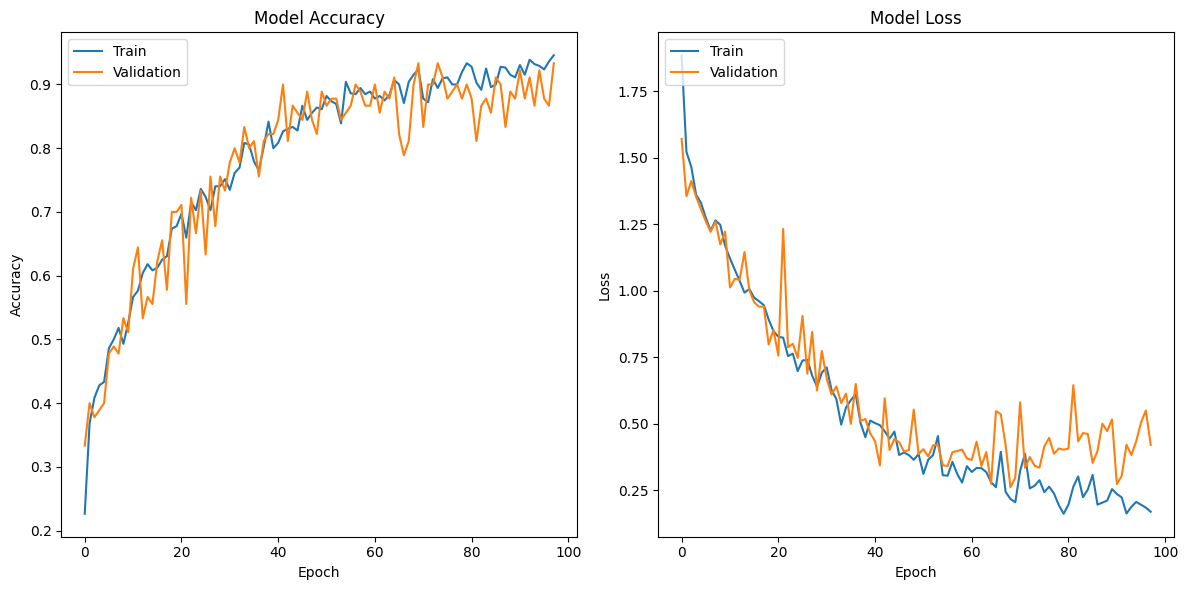

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

best_epoch = val_accuracy.index(max(val_accuracy)) + 1  # Add 1 because epochs are 1-indexed

print(f"Best Accuracy: {accuracy[best_epoch-1]:.4f} at Epoch {best_epoch}")
print(f"Best Validation Accuracy: {val_accuracy[best_epoch-1]:.4f} at Epoch {best_epoch}")

Best Accuracy: 0.9236 at Epoch 70
Best Validation Accuracy: 0.9333 at Epoch 70


In [ ]:
y_hat_with_cnn = model.predict(X_test)
test_with_cnn = model.evaluate(X_test, y_test)
print('Test Loss = ', test_with_cnn[0], 'Test Accuracy = ', test_with_cnn[1])

3/3 [==============================] - 0s 14ms/step - loss: 0.3357 - accuracy: 0.9111
Test Loss =  0.3357163369655609 Test Accuracy =  0.9111111164093018


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

3/3 [==============================] - 0s 12ms/step


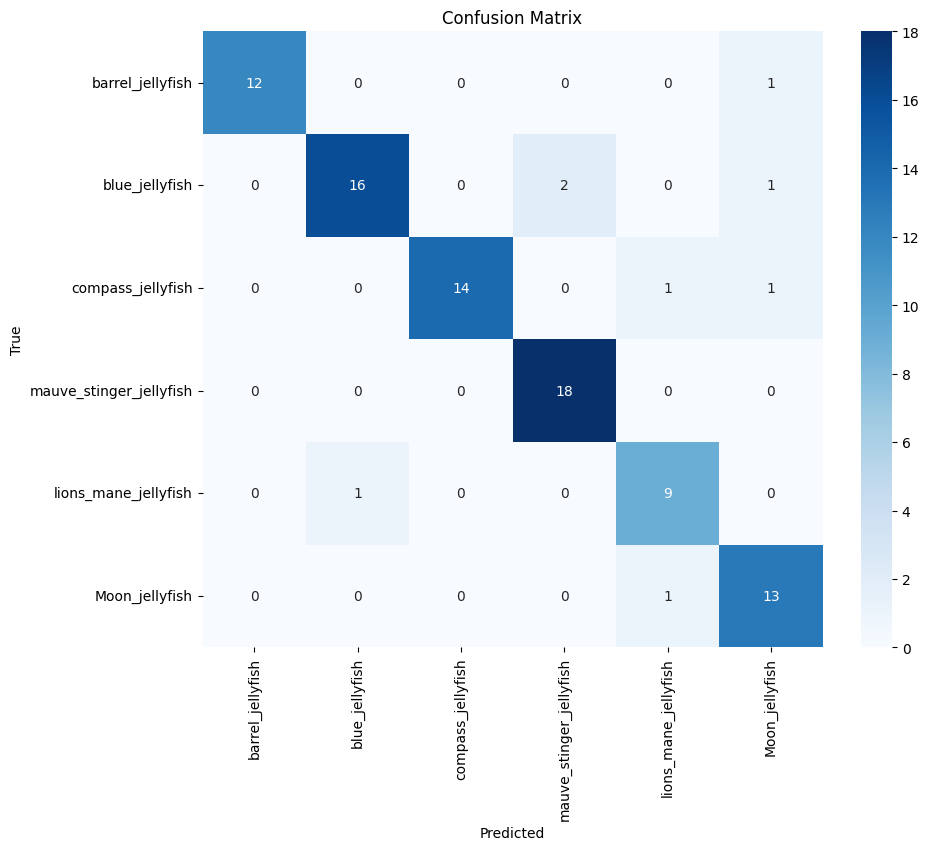

Classification Report:
                         precision    recall  f1-score   support

       barrel_jellyfish       1.00      0.92      0.96        13
         blue_jellyfish       0.94      0.84      0.89        19
      compass_jellyfish       1.00      0.88      0.93        16
mauve_stinger_jellyfish       0.90      1.00      0.95        18
   lions_mane_jellyfish       0.82      0.90      0.86        10
         Moon_jellyfish       0.81      0.93      0.87        14

               accuracy                           0.91        90
              macro avg       0.91      0.91      0.91        90
           weighted avg       0.92      0.91      0.91        90



In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("==================================")
print('Classification Report:')
print(classification_report(y_true, y_pred_classes, target_names=classes))



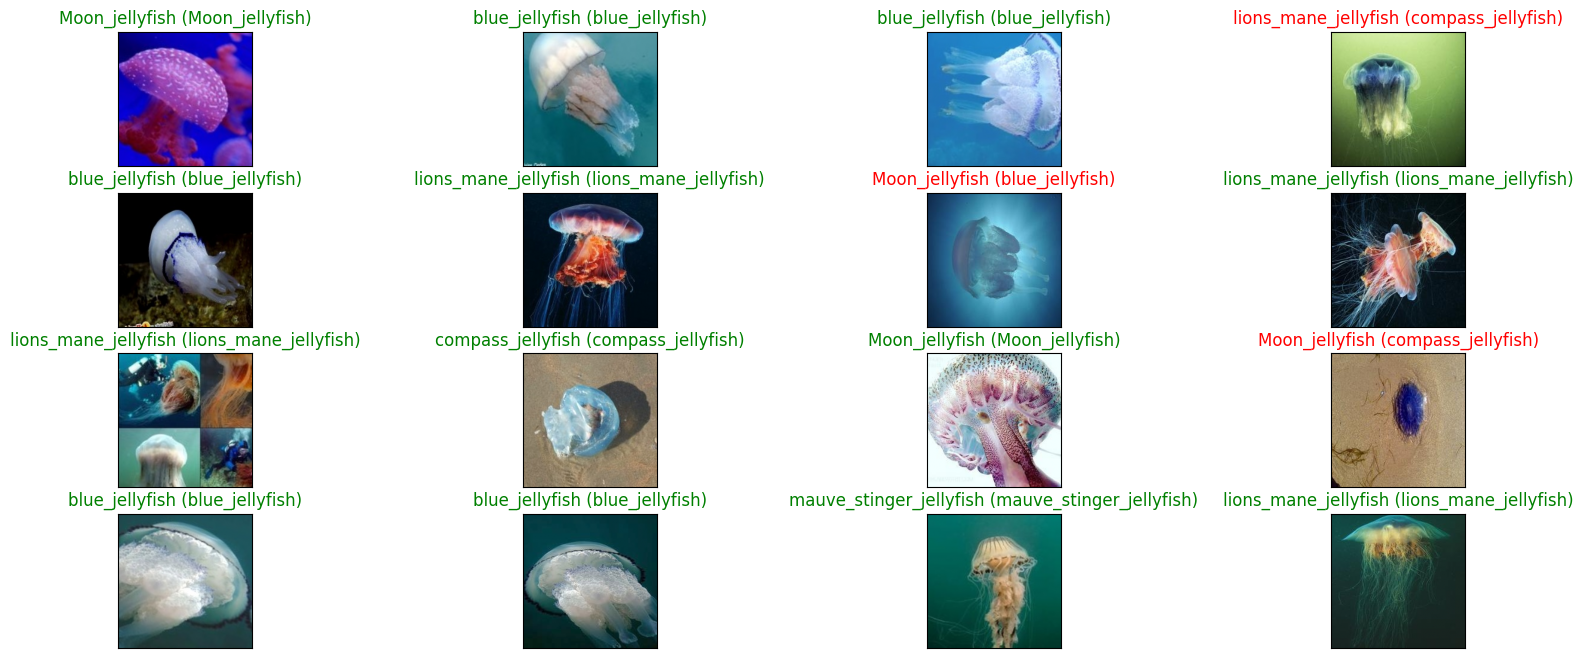

In [ ]:
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_hat_with_cnn[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(classes[pred_idx], classes[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

In [ ]:
model.save('pi_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Import Library yang Diperlukan
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from google.colab import files
import matplotlib.pyplot as plt

# Upload Foto
uploaded = files.upload()

# Muat Gambar
for fn in uploaded.keys():
    # Memuat gambar
    img_path = fn
    img = image.load_img(img_path, target_size=(224, 224))  # Sesuaikan ukuran
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Preprocessing gambar
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalisasi

    # Lakukan Prediksi Menggunakan Model
    predictions = model.predict(img_array)

    # Definisikan kelas-kelas
    class_names = [
        'Moon jellyfish (Aurelia aurita)',
        'Barrel jellyfish (Rhizostoma pulmo)',
        'Blue jellyfish (Cyanea lamarckii)',
        'Compass jellyfish (Chrysaora hysoscella)',
        'Lion’s mane jellyfish (Cyanea capillata)',
        'Mauve stinger (Pelagia noctiluca)'
    ]

    predicted_class = class_names[np.argmax(predictions[0])]

    print(f'Prediksi: {predicted_class}')
